In [1]:
#| default_exp wf2

# Wright–Fisher v2 Setup

A compact playground for building a Wright–Fisher style breeding workflow. We start from msprime founders, layer on a single additive trait, and confirm that phenotypes behave as expected.

We will:
- simulate a founder population with `msprime_pop` to get realistic haplotypes and a genetic map.
- sample an additive-only trait architecture scaled to a target additive variance.
- draw noisy phenotypes at a chosen heritability so the pipeline is ready for downstream selection experiments.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from numpy.random import default_rng
import msprime
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from IPython.display import display

from chewc.structs import Population, GeneticMap, add_trait
from chewc.pheno import calculate_phenotypes

plt.style.use('seaborn-v0_8')

/home/glect/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
#| export
def msprime_pop(
    key: jax.Array,
    n_ind: int,
    n_chr: int,
    n_loci_per_chr: int,
    ploidy: int = 2,
    effective_population_size: int = 5_000,
    mutation_rate: float = 1e-7,
    recombination_rate_per_chr: float = 1e-8,
    maf_threshold: float = 0.05,
    base_chr_length: int = 500_000,
    num_simulated_individuals: Optional[int] = None,
    enforce_founder_maf: bool = True,
) -> Tuple[Population, GeneticMap]:
    """Simulate a padded founder population from an msprime ancestry model.

    The output matches the lightweight `Population`/`GeneticMap` structures used by the
    workflow notebooks so it can plug straight into trait sampling, phenotype simulation,
    and selection routines.
    """
    if n_ind <= 0:
        raise ValueError('n_ind must be positive.')
    if n_chr <= 0:
        raise ValueError('n_chr must be positive.')
    if n_loci_per_chr <= 0:
        raise ValueError('n_loci_per_chr must be positive.')

    if num_simulated_individuals is None:
        multiplier = 5 if enforce_founder_maf else 2
        num_simulated_individuals = max(n_ind * multiplier, 2 * n_ind)
    if num_simulated_individuals < n_ind:
        raise ValueError('num_simulated_individuals must be >= n_ind.')

    key, seed_key, numpy_seed_key = jax.random.split(key, 3)
    random_seed = int(jax.random.randint(seed_key, (), 0, 2**31 - 1).item())
    numpy_seed = int(jax.random.randint(numpy_seed_key, (), 0, 2**31 - 1).item())
    rng = default_rng(numpy_seed)

    chromosome_lengths = [base_chr_length] * n_chr
    cumulative = np.cumsum([0] + chromosome_lengths)
    rate_map = msprime.RateMap(
        position=cumulative,
        rate=[recombination_rate_per_chr] * n_chr,
    )

    ts = msprime.sim_ancestry(
        samples=num_simulated_individuals * ploidy,
        population_size=effective_population_size,
        recombination_rate=rate_map,
        random_seed=random_seed,
    )
    mts = msprime.sim_mutations(ts, rate=mutation_rate, random_seed=random_seed + 1)

    true_num_individuals = mts.num_samples // ploidy
    founder_indices = np.sort(rng.choice(true_num_individuals, n_ind, replace=False))

    geno = np.zeros((n_ind, n_chr, ploidy, n_loci_per_chr), dtype=np.uint8)
    locus_positions = []
    chr_lengths_cm = []

    all_variants = list(mts.variants())

    for chr_idx in range(n_chr):
        chr_left, chr_right = rate_map.left[chr_idx], rate_map.right[chr_idx]
        chr_variants = [
            var for var in all_variants
            if chr_left <= var.site.position < chr_right and len(var.alleles) == 2
        ]

        if not chr_variants:
            raise RuntimeError(f'No bi-allelic SNPs found on chromosome {chr_idx}.')

        def maf_in_founders(var):
            g = var.genotypes.reshape(true_num_individuals, ploidy)
            founder_g = g[founder_indices]
            p = founder_g.mean()
            return min(p, 1 - p)

        if enforce_founder_maf:
            eligible = [var for var in chr_variants if maf_in_founders(var) >= maf_threshold]
        else:
            eligible = [var for var in chr_variants if maf_in_founders(var) > 0]

        if len(eligible) < n_loci_per_chr:
            raise RuntimeError(
                f'Only {len(eligible)} SNPs passed the MAF filter on chromosome {chr_idx}; '
                'consider lowering maf_threshold or increasing the mutation rate.'
            )

        selected_idx = rng.choice(len(eligible), n_loci_per_chr, replace=False)
        selected = [eligible[i] for i in selected_idx]
        selected.sort(key=lambda v: v.site.position)

        chr_positions = []
        for snp_pos, snp in enumerate(selected):
            genotypes = snp.genotypes.reshape(true_num_individuals, ploidy)
            founder_genotypes = genotypes[founder_indices]
            geno[:, chr_idx, :, snp_pos] = founder_genotypes

            pos_cm = (snp.site.position - chr_left) * recombination_rate_per_chr * 100.0
            chr_positions.append(pos_cm)

        locus_positions.append(jnp.array(chr_positions, dtype=jnp.float32))
        chr_lengths_cm.append(chr_positions[-1] if chr_positions else 0.0)

    ibd = np.arange(n_ind * n_chr * ploidy * n_loci_per_chr, dtype=np.int32)
    ibd = ibd.reshape(n_ind, n_chr, ploidy, n_loci_per_chr)

    meta = np.stack([
        np.arange(n_ind, dtype=np.int32),
        np.full(n_ind, -1, dtype=np.int32),
        np.full(n_ind, -1, dtype=np.int32),
        np.zeros(n_ind, dtype=np.int32),
    ], axis=-1)

    population = Population(
        geno=jnp.array(geno, dtype=jnp.uint8),
        ibd=jnp.array(ibd, dtype=jnp.int32),
        meta=jnp.array(meta, dtype=jnp.int32),
    )

    chromosome_lengths_cm = jnp.array(chr_lengths_cm, dtype=jnp.float32)
    genetic_map = GeneticMap(
        chromosome_lengths=chromosome_lengths_cm,
        locus_positions=locus_positions,
    )

    return population, genetic_map

In [4]:
master_key = jax.random.PRNGKey(2024)
pop_key, trait_key, pheno_key = jax.random.split(master_key, 3)

founder_config = dict(
    n_ind=48,
    n_chr=3,
    n_loci_per_chr=40,
    mutation_rate=1e-7,
    recombination_rate_per_chr=1e-8,
    base_chr_length=500_000,
    effective_population_size=5_000,
    num_simulated_individuals=800,
    maf_threshold=0.05,
)

founder_pop, genetic_map = msprime_pop(pop_key, **founder_config)

print(f'Founder genotype array shape: {founder_pop.geno.shape}')
allele_counts = founder_pop.geno.sum(axis=2).reshape(founder_pop.geno.shape[0], -1)
print(f'Mean allele dosage across founders: {float(allele_counts.mean()):.2f}')

Founder genotype array shape: (48, 3, 2, 40)
Mean allele dosage across founders: 0.62


In [5]:
map_summary = pd.DataFrame({
    'chromosome': np.repeat(np.arange(founder_config['n_chr']), founder_config['n_loci_per_chr']),
    'position_cM': np.concatenate([np.asarray(pos) for pos in genetic_map.locus_positions]),
})

display(map_summary.groupby('chromosome')['position_cM'].agg(['min', 'max', 'count']))

,min,max,count
chromosome,,,
0,0.008855,0.490694,40
1,0.022942,0.481344,40
2,0.008968,0.499258,40


In [6]:
trait = add_trait(
    key=trait_key,
    founder_pop=founder_pop,
    n_qtl_per_chr=6,
    mean=jnp.array([0.0]),
    var_a=jnp.array([1.0]),
    var_d=jnp.array([0.0]),
    sigma=jnp.array([[1.0]], dtype=jnp.float32),
)

print(f'Total QTL sampled: {trait.qtl_effects.shape[0]}')
print(f'Trait intercept: {float(trait.intercept[0]):.3f}')

Total QTL sampled: 18
Trait intercept: 0.173


,mean,std
phenotype,-0.108091,1.537079
tbv,-0.173355,1.010582


Correlation (phenotype, TBV): 0.693


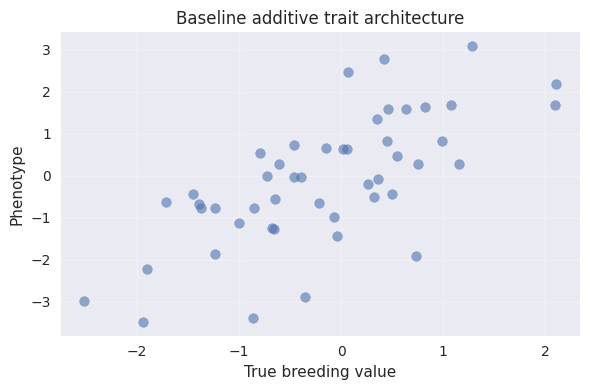

In [7]:
heritability = jnp.array([0.4], dtype=jnp.float32)
phenotypes, tbv = calculate_phenotypes(
    key=pheno_key,
    population=founder_pop,
    trait=trait,
    heritability=heritability,
)

results = pd.DataFrame({
    'phenotype': np.asarray(phenotypes[:, 0]),
    'tbv': np.asarray(tbv[:, 0]),
})

display(results.describe().T[['mean', 'std']])
print(f"Correlation (phenotype, TBV): {results.corr().loc['phenotype', 'tbv']:.3f}")

plt.figure(figsize=(6, 4))
plt.scatter(results['tbv'], results['phenotype'], alpha=0.6)
plt.xlabel('True breeding value')
plt.ylabel('Phenotype')
plt.title('Baseline additive trait architecture')
plt.grid(True, alpha=0.3)
plt.tight_layout()